In [820]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy.stats
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import r2_score

In [962]:
if False:
    df = pd.read_csv('data/bquxjob_4fc765cf_1949f117271.csv')
# Sawtooth
else:
    #df = pd.read_csv('data/bquxjob_8118ddd_1949ea1f4a9.csv')
    #df = pd.read_csv('data/bquxjob_672527f8_1949f0450c8.csv')
    df = pd.read_csv('data/bquxjob_12771f0c_194a898f6e6.csv') # Break out 5G NSA
# Snapped to 2db

In [963]:
df['cleaned_mno'].value_counts()[0:10]

cleaned_mno
O2                         1094
V                          1009
EE                          849
raw_Tesco Mobile_Tesco      820
raw_giffgaff_giffgaff       812
raw_3_Three Mobile          787
raw_Sky Mobile_Sky          762
raw_Lebara_Lebara           668
raw_iD Mobile_iD Mobile     628
raw_SMARTY_Smarty           591
Name: count, dtype: int64

In [964]:
df.dtypes

c                              int64
cleaned_mno                   object
test_status                    int64
QOS_SignalStrength           float64
Connection_Category_clean     object
dtype: object

In [965]:
df['Connection_Category_clean'].isna().sum()
# Some have the connection category undefined

515

In [966]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
1219,29,NaN,0,-122.0,5G NSA
5187,2,raw_O2_O2 - UK,-1,-56.0,3
330,2,raw_3_Smarty,0,-116.0,4
1879,8,V,1,-70.0,5G NSA
12774,35,raw_Talkmobile_Vodafone,0,-112.0,4


## Test status 0/1

In [967]:
def clean_test_status(status):
    return status.apply(lambda x: '1' if x==0 else 0)

In [968]:
df['test_status'] = clean_test_status(df['test_status'])

## Drop all but big 4 MNOs

In [969]:
df_big_four = df[df['cleaned_mno'].apply(lambda x:x in ['O2','3','V','EE'])]

In [970]:
df_big_four.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
4371,2410,O2,1,-78.0,5G NSA
4477,4,O2,0,-94.0,5 SA
2041,203,V,1,-60.0,5G NSA
3413,1352,EE,0,-124.0,4
3184,4,EE,1,-62.0,NaN


In [971]:
if False:
    df = df_big_four

In [972]:
def get_baseline_success(df):
    print(df.groupby('test_status')['c'].sum())
    vals = df.groupby('test_status')['c'].sum().values
    rate = 100 * vals[1] / float(vals[0] + vals[1])
    print('Baseline success = {:.1f}%'.format(rate))
    return rate
# This is the baseline succes rate 

In [973]:
get_baseline_success(df)

test_status
0    1421839
1    4449834
Name: c, dtype: int64
Baseline success = 75.8%


75.78477207433043

In [974]:
get_baseline_success(df_big_four)

test_status
0     807084
1    2624085
Name: c, dtype: int64
Baseline success = 76.5%


76.47787095301922

In [975]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
3763,8,O2,0,-94.0,5 SA
6685,1,raw_BT Mobile_BT,0,-74.0,4
12906,699,raw_iD Mobile_iD Mobile,1,-118.0,5G NSA
816,1,raw_SMARTY_SMARTY,1,-112.0,4
1220,8,NaN,0,-62.0,4


In [976]:
df[df['QOS_SignalStrength'] == -16]['c'].sum()

18

## Drop category and MNO and aggregate

In [977]:
df.head()

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
0,1,raw_Sky Mobile_O2,1,-82.0,5G NSA
1,1,raw_Vodafone_50+,1,-106.0,4
2,1,raw_Vodafone_TalkMobile,1,-94.0,4
3,1,raw_Tesco Mobile_O2,0,-118.0,4
4,1,raw_Talk Talk_EE,1,-118.0,4


In [978]:
g = df.groupby(['QOS_SignalStrength','test_status'])
# Drops technology and MNO

In [979]:
if False:
    g = df.groupby(['QOS_SignalStrength','test_status','Connection_Category_clean'])
# Drops MNO only

## Sum over groups

In [980]:
aggregated = g.apply(lambda x: x['c'].sum())

In [981]:
aggregated[aggregated.index.get_level_values(0) == -17]

Series([], dtype: int64)

In [982]:
aggregated.sample(10)

QOS_SignalStrength  test_status
-66.0               1               17015
-132.0              1                 190
-50.0               0                  49
-118.0              0               71748
-40.0               1                  25
-90.0               0               30078
-52.0               0                3394
-104.0              0               83146
-114.0              1              158799
-14.0               1                   7
dtype: int64

In [983]:
n = aggregated.groupby(level=[0]).sum()

In [984]:
n.sample(5)

QOS_SignalStrength
-68.0     27657
-34.0        35
-126.0     8805
-2.0          9
-72.0     45614
dtype: int64

## Normalise

In [985]:
normalised = aggregated/ n

In [986]:
normalised.sample(5)

QOS_SignalStrength  test_status
-22.0               0              0.210526
-110.0              1              0.689962
-52.0               0              0.585072
-78.0               0              0.136250
-104.0              0              0.206751
dtype: float64

In [987]:
len(pd.unique(normalised.index.get_level_values(0)))

70

In [988]:
normalised = normalised[normalised.index.get_level_values(1) == '1']
# Drop failure rate

In [989]:
len(pd.unique(normalised.index.get_level_values(0)))

70

In [990]:
normalised.sample(5)

QOS_SignalStrength  test_status
-118.0              1              0.418131
-136.0              1              0.237354
-44.0               1              0.754584
-56.0               1              0.784732
-66.0               1              0.849985
dtype: float64

In [991]:
normalised = normalised.droplevel(1)

In [992]:
normalised.sample(5)

QOS_SignalStrength
-126.0    0.185009
-60.0     0.826665
-136.0    0.237354
-110.0    0.689962
-80.0     0.862945
dtype: float64

In [993]:
nDict = n.to_dict()

In [994]:
###normalised['n'] = map(lambda x:nDict[x],normalised.index.values)

In [995]:
normalised = pd.DataFrame(index = normalised.index, data = {'rate' : normalised.values\
                          ,'n':map(lambda x:nDict[x],normalised.index.values)})
# Turn MultiIndex series into dataframe

In [996]:
normalised.sample(5)

,rate,n
QOS_SignalStrength,,
-88.0,0.856275,179565
-92.0,0.850960,237125
-12.0,0.727273,11
-104.0,0.793249,402156
-62.0,0.841825,10501


## Add CIs

In [997]:
proportion_confint(1,100, method = 'binom_test',alpha = 0.95)

(0.009900989118484497, 0.019801982164531506)

In [998]:
def get_ci(row, alpha = 0.1):
    return proportion_confint(int(row['rate'] * row['n']), row['n'], method = 'binom_test',alpha = alpha)

In [999]:
normalised['intervals'] = normalised.apply(get_ci,axis = 1)

In [1000]:
normalised.sample(5)

,rate,n,intervals
QOS_SignalStrength,,,
-56.0,0.784732,3419,"(0.7728796941043257, 0.7961317297157575)"
-36.0,0.666667,30,"(0.5079175758371133, 0.8010480626812255)"
-100.0,0.824796,352909,"(0.8237405917114049, 0.8258473677409809)"
-28.0,0.785714,14,"(0.5360658537325887, 0.918522846000278)"
-94.0,0.849711,269421,"(0.8485732987021648, 0.8508411233427429)"


In [1001]:
def get_db_at_rate(df,rate = 0.5):
    return df[(df['rate'] > rate) & (df.index > -130)].sort_index().index[0]
# Add a hack to exclude very low signal with high rate but low n

## Fit a logistic

In [1002]:
def logifunc(x,A,x0,k,off):
    # Max val = off + A
    # Mid point = x0
    # Steepness = k
    return A / (1 + np.exp(-k*(x-x0)))+off

In [1097]:
def fit_logistic(normalised, lower = -140, upper = -70):

    if type(normalised.index) == pd.core.indexes.multi.MultiIndex:
        normalised_subset = normalised.loc[(normlised.index.get_level_values(0) > lower) & (normlised.index.get_level_values(0) < upper)]
        # Need to filter differently on Multiindex if it's a group
    else:    
        normalised_subset = normalised[(normalised.index > lower) & (normalised.index < upper)]
        # Hard code dropping extremes

    p0 = [0.6,-120,0.05,0.2]
    # Estimate initial parameters

    try:
        popt, pcov = curve_fit(logifunc, normalised_subset.index, normalised_subset['rate'],p0 = p0)
        fitted = True
    except:
        print('*** Fit not converging')
        fitted = False
        fit_string = ''

    if fitted:
        r2 = r2_score(normalised_subset['rate'], logifunc(normalised_subset.index, *popt))
    
        fit_string = 'r^2 = {:.3f}'.format(r2)
        #fit_string = fit_string +'\n' + ','.join(['{:.2f}'.format(p) for p in popt])
        fit_string = fit_string +'\n' + 'Slope = {:.2f}'.format(popt[2])
        fit_string = fit_string +'\n' + 'Lower = {:.2f}'.format(popt[3])
        fit_string = fit_string +'\n' + 'Upper = {:.2f}'.format(popt[0] + popt[3])

    if fitted:
        return popt,pcov,normalised_subset,r2,fit_string,fitted
    else:
        return None,None,normalised_subset,None,fit_string,fitted

## Plot (Full Dataset)

In [861]:
normalised['intervals'].sample(5)

QOS_SignalStrength
-40.0        (0.5358558104839005, 0.794429610353782)
-126.0    (0.17825410266566397, 0.19193961222574085)
-4.0        (0.3427520079519535, 0.7107140209955374)
-58.0       (0.8191625130395154, 0.8369459123122895)
-42.0        (0.5943857944452791, 0.838339062035409)
Name: intervals, dtype: object

In [1095]:
def plot_rate(df, name = 'trash',add_rate = False, add_fit = True):
    ax = plt.subplot()
    
    x_lims = [-140,-40]
    
    main_colour = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    
    df.plot(kind = 'line', ax = ax, y = 'rate', legend = False)
    # Plot rate

    popt,pcov,normalised_subset,r2,fit_string, fitted = fit_logistic(df)
    
    if fitted:
        _ = plt.plot(normalised_subset.index,logifunc(normalised_subset.index, *popt), linestyle = '--')
    
        plt.annotate(fit_string, xy = (0.6,0.1),xycoords = 'axes fraction')
        # Add fit
    
    plt.title('{:s} (n = {:.1f} k)'.format(name,df['n'].sum()/1000.))
    # Label with total sample size
    
    ax.fill_between(df.index, df['intervals'].apply(lambda x:x[0]), df['intervals'].apply(lambda x:x[1]), alpha = 0.5)
    # Add CIs

    if add_rate:
        for rate in [0.5, 0.75, 0.85]:
            plt.plot([get_db_at_rate(df,rate), get_db_at_rate(df,rate)],[0,rate], color = 'grey', linestyle = '--')
            plt.plot([x_lims[0],get_db_at_rate(df,rate)], [rate,rate], color = 'grey', linestyle = '--')
        
            plt.annotate('{:d}% : {:.1f} dB'.format(int(rate * 100), get_db_at_rate(df,rate)),xy = (-139, rate + 0.015),xycoords = 'data', color = 'grey')
        # Add annotations and lines at certain rates
    
    plt.xlim(x_lims)
    plt.ylim([0.0,1.0])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Drop frame
    
    plt.ylabel('Connectivity Success Rate')
    plt.xlabel('Signal Strength (dB)')
    # Label
    
    plt.savefig('figs/{:s}.png'.format(name),dpi = 300)
    plt.savefig('figs/{:s}.svg'.format(name))
    # Save

    plt.show()

r^2 = 0.99
slope = 0.24
Lower = 0.67
Upper = 0.85


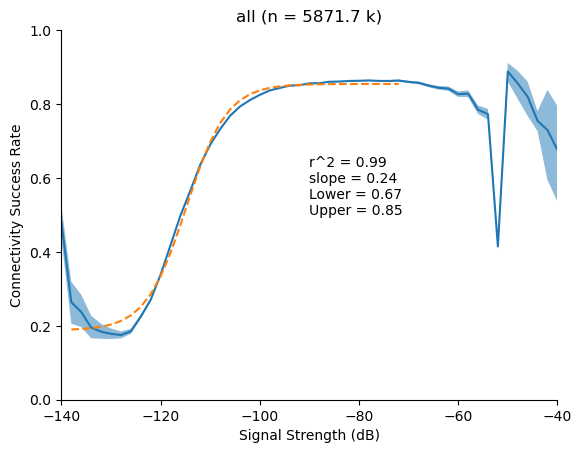

In [1011]:
plot_rate(normalised,name = 'all')

## Plot by MNO

In [1062]:
def clean_non_big_four(mno):

    if mno in ['O2','3','V','EE']:
        return mno
    else:
        return 'other'

In [1063]:
df['cleaned_mno'] = df['cleaned_mno'].apply(clean_non_big_four)

In [1064]:
g = df.groupby(['QOS_SignalStrength','test_status','cleaned_mno'])

In [1065]:
aggregated = g.apply(lambda x: x['c'].sum())

In [1066]:
n = aggregated.groupby(level=[0,2]).sum()
# Sum over groups of (signal,mno)

nDict = n.to_dict()

In [1067]:
normalised = aggregated / n

In [1068]:
normalised = normalised[normalised.index.get_level_values(2) == '1']
normalised = normalised.droplevel(2)
# Drop failure rate

In [1090]:
def process_group(group,name = 'mno', add_rate = False):

    name = '{:s}_{:s}'.format(name, group.index[0][1].lower())
    
    group = pd.DataFrame(index = group.index, data = {'rate' : group.values\
                          ,'n':map(lambda x:nDict[x],group.index.values)})
    group = group.droplevel(1)
    # Now we can drop the MNO index
    
    group['intervals'] = group.apply(get_ci,axis = 1)
    plot_rate(group, name = name, add_rate = add_rate)
    #return group

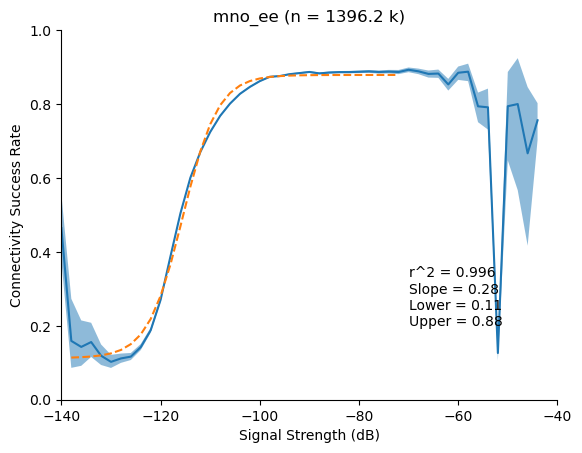

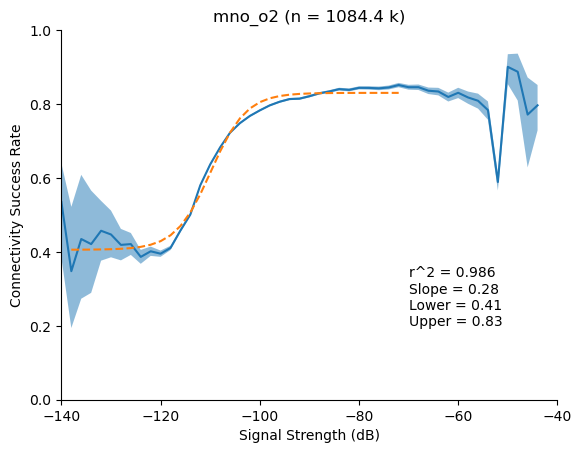

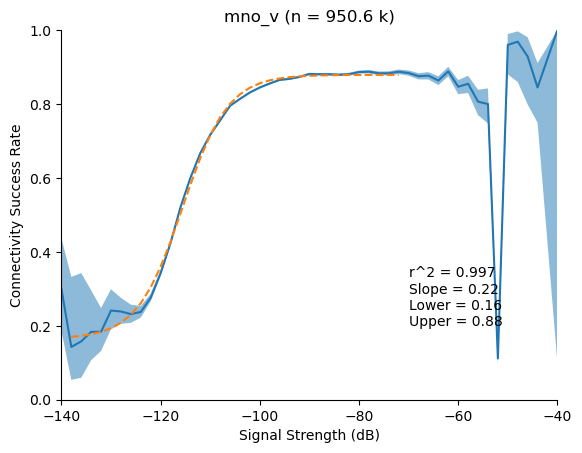

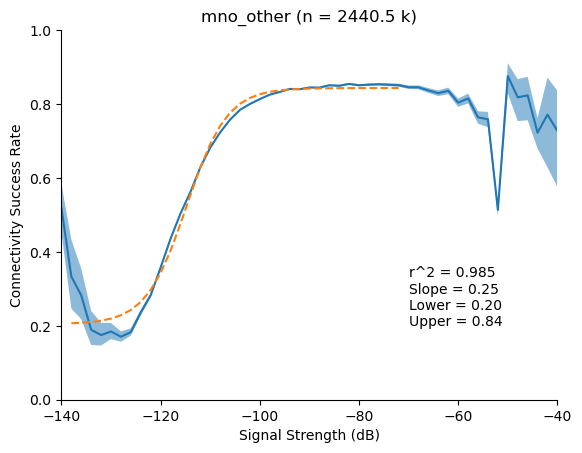

cleaned_mno
EE       None
O2       None
V        None
other    None
dtype: object

In [1091]:
normalised.groupby('cleaned_mno').apply(lambda x: process_group(x,name = 'mno'))

## Plot by Technology

In [818]:
df.head()

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
0,1,raw_Sky Mobile_O2,1,-82.0,5G NSA
1,1,raw_Vodafone_50+,1,-106.0,4
2,1,raw_Vodafone_TalkMobile,1,-94.0,4
3,1,raw_Tesco Mobile_O2,0,-118.0,4
4,1,raw_Talk Talk_EE,1,-118.0,4


*** Fit not converging


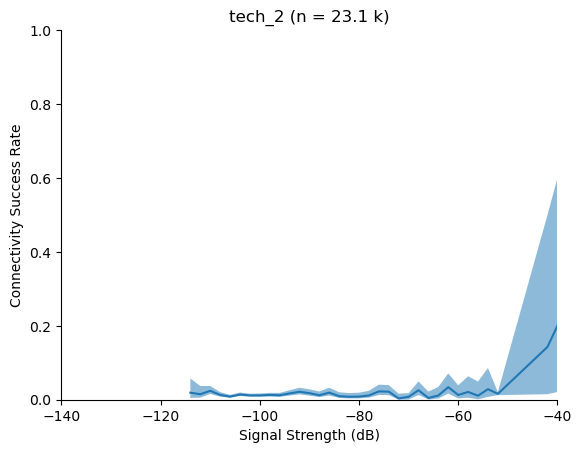

C:\Users\Alex.Rutherford\AppData\local\conda3\Lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


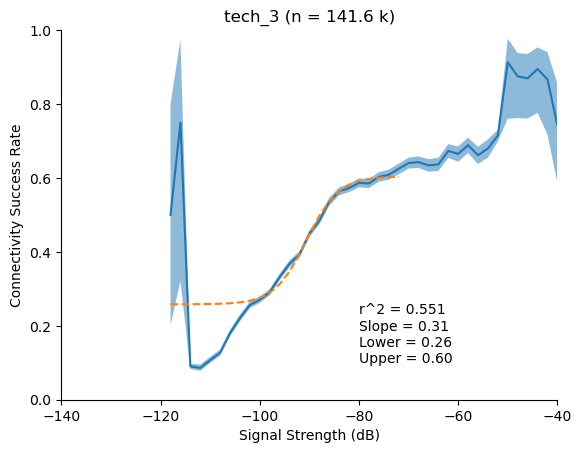

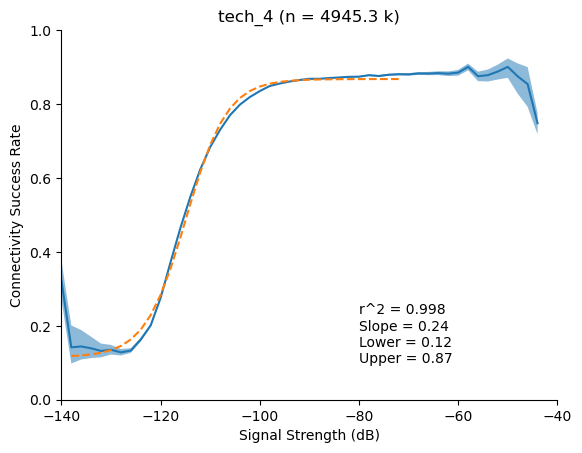

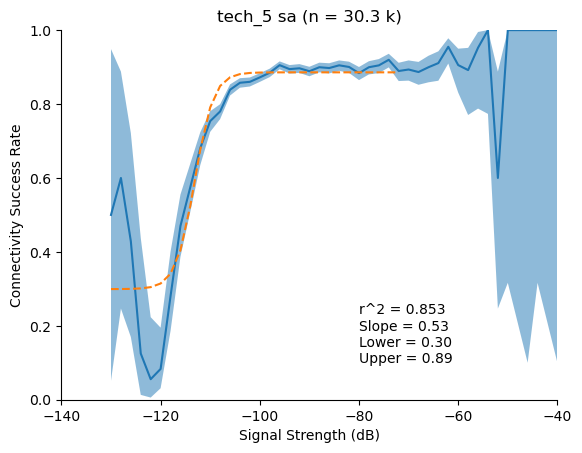

In [ ]:
g = df.groupby(['QOS_SignalStrength','test_status','Connection_Category_clean'])
aggregated = g.apply(lambda x: x['c'].sum())
n = aggregated.groupby(level=[0,2]).sum()
# Sum over groups of (signal,tech)
nDict = n.to_dict()
normalised = aggregated / n
normalised = normalised[normalised.index.get_level_values(2) == '1']
normalised = normalised.droplevel(2)
# Drop failure rate
normalised.groupby('Connection_Category_clean').apply(lambda x: process_group(x,name = 'tech',add_rate=False))